<a href="https://colab.research.google.com/github/priyal6/ML/blob/main/Sentiment_Analysis_on_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data = pd.read_csv(r"amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
print(f"Feature names: {data.columns.values}")

Feature names: ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [5]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:
data.dropna(inplace= True)

In [8]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [9]:
data['length'] = data['verified_reviews'].apply(len)

In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [11]:
print(f"'verified_reviews':column value:{data.iloc[10]['verified_reviews']}")
print(f"'verified_reviews length':column value:{len(data.iloc[10]['verified_reviews'])}")
print(f"'length' column value : {data.iloc[10]['length']}")






'verified_reviews':column value:"I sent it to my 85 year old Dad, and he talks to it constantly."
'verified_reviews length':column value:65
'length' column value : 65


In [12]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [13]:
len(data)

3149

In [14]:
print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


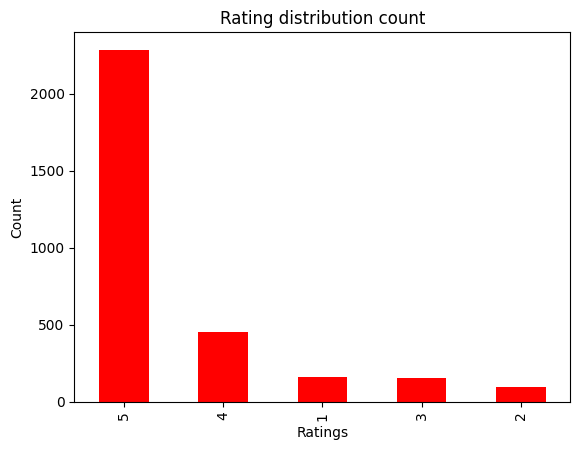

In [15]:
data['rating'].value_counts().plot.bar(color ='red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

([<matplotlib.patches.Wedge at 0x7e8cece7a560>,
 [Text(-0.7168724685549036, 0.8343223980141004, ''),
  Text(0.3279993074405714, -1.0499602155884316, ''),
  Text(0.873384483251418, -0.6687297992580064, ''),
  Text(1.0365910478276685, -0.36807472008212716, ''),
  Text(1.0950633344547087, -0.10409751934092915, '')])

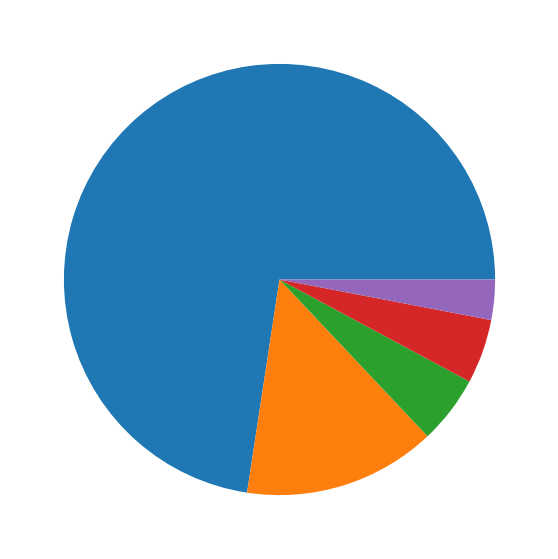

In [16]:
fig = plt.figure(figsize=(7,7))
plt.pie(data['rating'].value_counts()/data.shape[0])

In [17]:
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [18]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

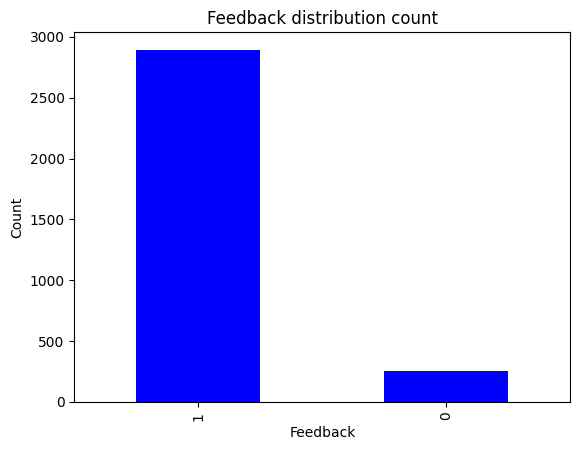

In [19]:
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [20]:
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")


Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of feedback'>

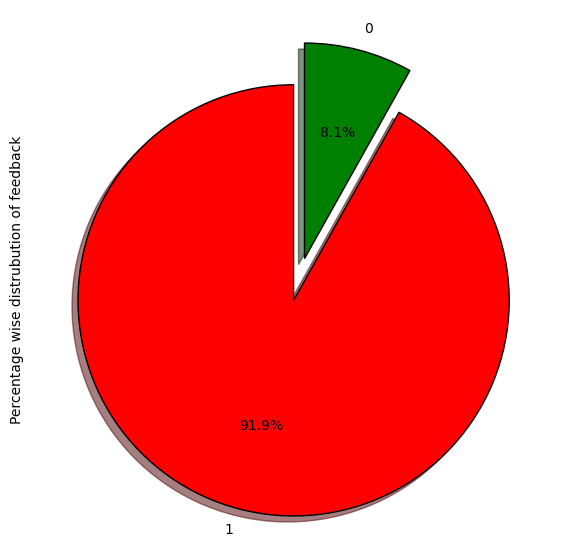

In [21]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [22]:
print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


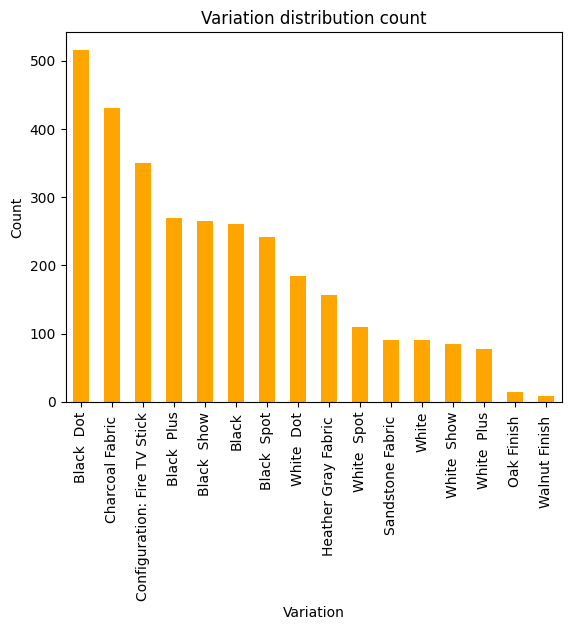

In [23]:
data['variation'].value_counts().plot.bar(color='orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [24]:
print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")


Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [25]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

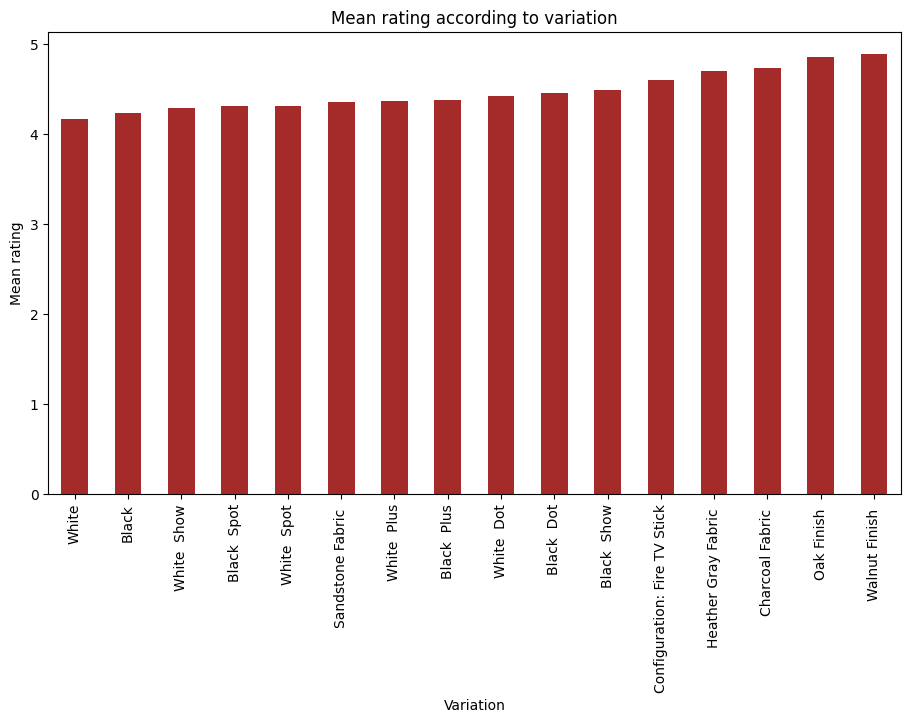

In [26]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

In [27]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

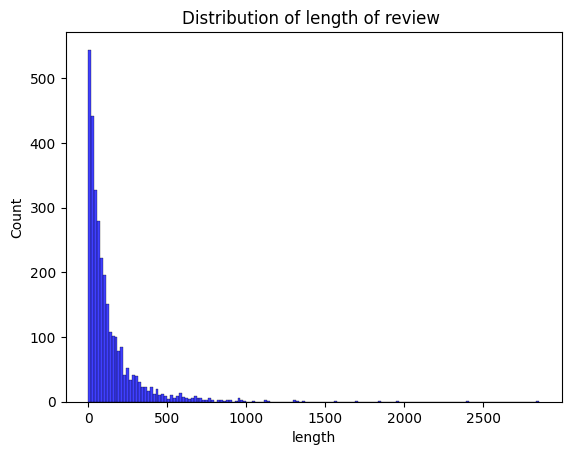

In [28]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

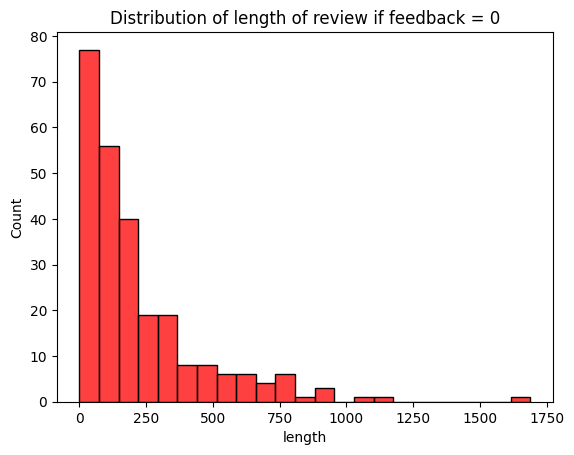

In [29]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

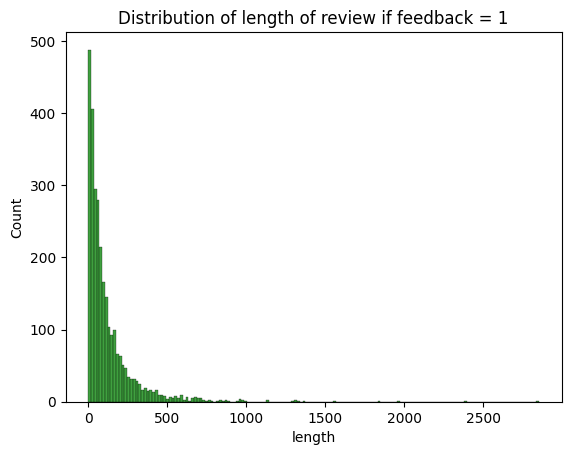

In [30]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

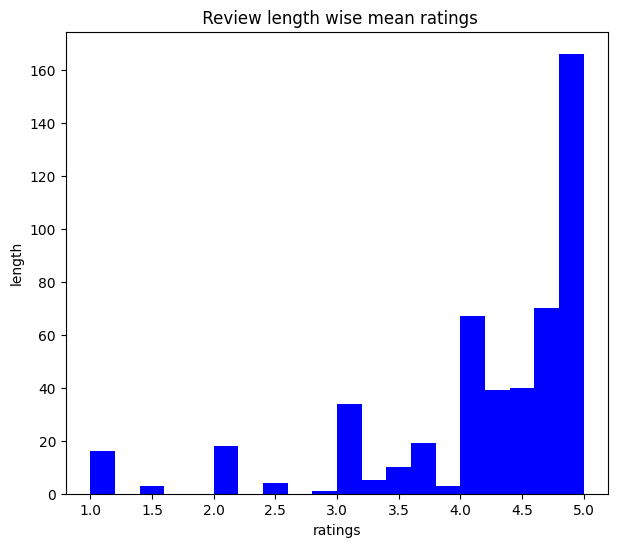

In [31]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [32]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

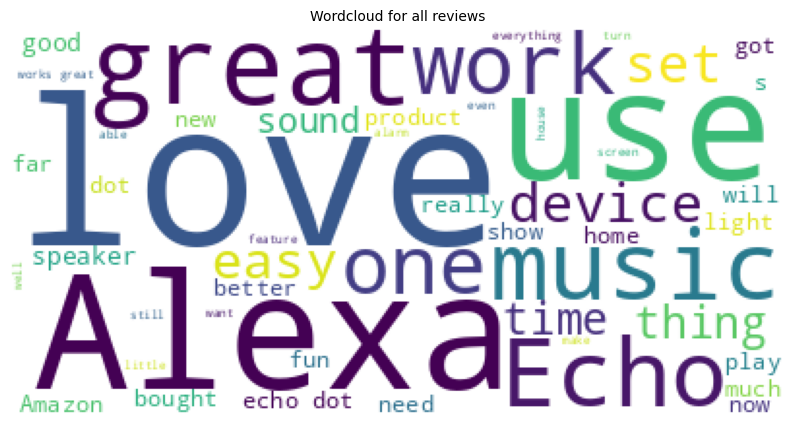

In [33]:
reviews = ''.join([review for review in data['verified_reviews']])


wc = WordCloud(background_color ='white',max_words = 50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()




In [34]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

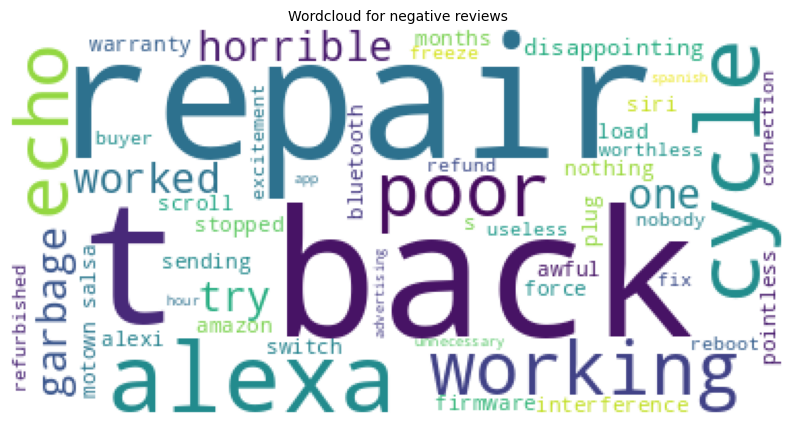

In [35]:
c = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

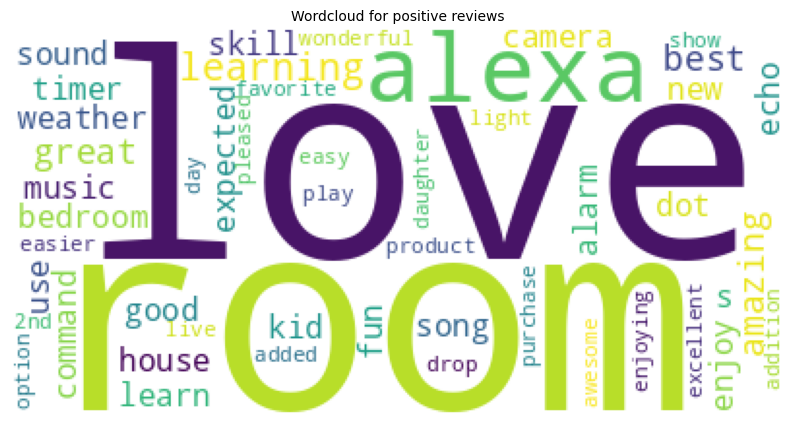

In [36]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [37]:
import re
corpus = []
stemmer = PorterStemmer()
for i in range(0,len(data)):
  review = re.sub('[^a-zA-z]',' ',data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if word not in STOPWORDS ]
  review = ' '.join(review)
  corpus.append(review)

In [38]:
cv = CountVectorizer(max_features = 2500)
X= cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [39]:
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [40]:
X.shape
y.shape

(3149,)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [42]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [43]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [44]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [45]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl,y_train)

RandomForestClassifier()

In [46]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.946031746031746


In [47]:
y_preds = model_rf.predict(X_test_scl)

In [48]:
cm = confusion_matrix(y_test, y_preds)

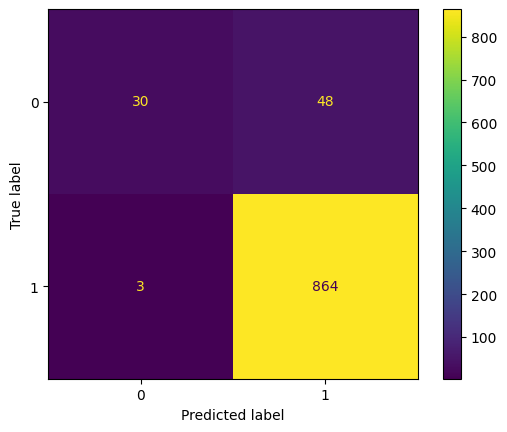

In [49]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [50]:
accuracies = cross_val_score(estimator = model_rf, X= X_train_scl, y= y_train, cv=10)
print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9305841217605924
Standard Variance : 0.0064009939012617065


In [51]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [53]:
y_preds = model_xgb.predict(X_test)


In [54]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 31  47]
 [ 13 854]]


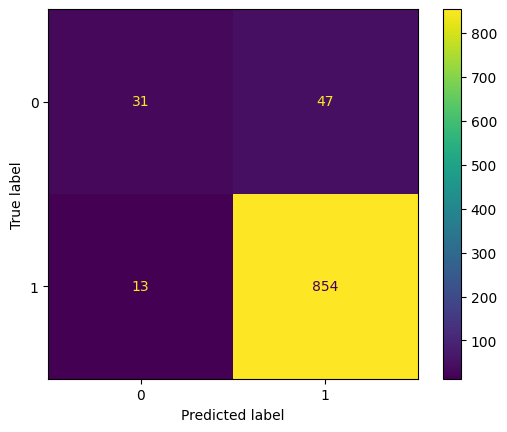

In [55]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [56]:
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

In [57]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [58]:
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9185185185185185


In [59]:
y_preds = model_dt.predict(X_test)

In [60]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 38  40]
 [ 88 779]]


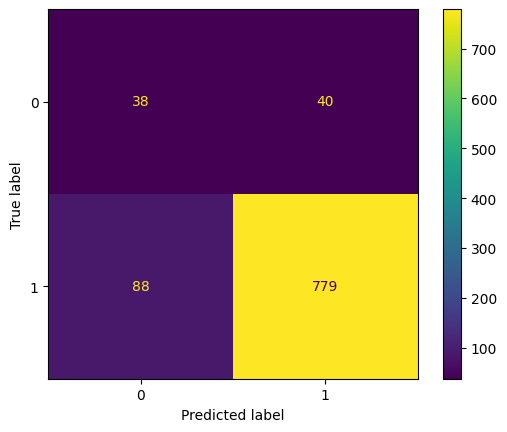

In [61]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()